In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import numpy as np
from tqdm import tqdm
import pickle
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
hgg = pd.read_parquet('/scratch365/cmoore24/training/data/hgg.parquet')
hbb = pd.read_parquet('/scratch365/cmoore24/training/data/hbb.parquet')

In [4]:
hgg = hgg[hgg['FatJets.msoftdrop'] < 140]
hgg = hgg[hgg['FatJets.msoftdrop'] > 90]
hgg = hgg[hgg['FatJets.pt'] < 600]
hgg = hgg[hgg['FatJets.pt'] > 450]
hgg['FatJets.mratio'] = hgg['FatJets.mass'].values/hgg['FatJets.msoftdrop'].values

In [5]:
hbb = hbb[hbb['FatJets.msoftdrop'] < 140]
hbb = hbb[hbb['FatJets.msoftdrop'] > 90]
hbb = hbb[hbb['FatJets.pt'] < 600]
hbb = hbb[hbb['FatJets.pt'] > 450]
hbb['FatJets.mratio'] = hbb['FatJets.mass'].values/hbb['FatJets.msoftdrop'].values

In [6]:
background = pd.read_parquet('/scratch365/cmoore24/training/data/qcd.parquet')
background['FatJets.mratio'] = background['FatJets.mass']/background['FatJets.msoftdrop']

In [7]:
background = background[background['FatJets.msoftdrop'] < 140]
background = background[background['FatJets.msoftdrop'] > 90]
background = background[background['FatJets.pt'] < 600]
background = background[background['FatJets.pt'] > 450]

In [8]:
var_keys = list(hgg.keys())

In [9]:
10000*len(background)/(len(background) + len(hbb) + len(hgg))

9046.959694333038

In [10]:
10000*len(hgg)/(len(background) + len(hbb) + len(hgg))

824.2782917198415

In [11]:
10000*len(hbb)/(len(background) + len(hbb) + len(hgg))

128.76201394712024

In [12]:
10000/len(background)#*(len(background))

0.021405667364491423

In [13]:
10000/len(hgg)

0.23494032515741

In [14]:
10000/len(hbb)

1.5039855617386073

In [15]:
# background = background[:len(hbb)]
# hgg = hgg[:len(hbb)]

In [16]:
items = [#'FatJets.area',
  #'FatJets.eta',
  #'FatJets.mass',
  #'FatJets.msoftdrop',
  'FatJets.n2b1',
  'FatJets.n3b1',
  #'FatJets.phi',
  #'FatJets.pt',
  'FatJets.nConstituents',
  'FatJets.color_ring',
  'FatJets.d2b1',
  'FatJets.u1',
  'FatJets.u2',
  'FatJets.u3',
  'FatJets.d3',
  'FatJets.m2',
  'FatJets.m3',
  'FatJets.n4',
  #'FatJets.mratio',
 'isSignal',
]

In [17]:
hgg['isSignal'] = np.ones_like(hgg[items[0]])

In [18]:
hbb['isSignal'] = np.ones_like(hbb[items[0]]) + 1

In [19]:
background['isSignal'] = np.zeros_like(background[items[0]])

In [20]:
# sizes = []
# for i in background:
#     sizes.append(len(background[i]))

# losses = [(x - min(sizes)) for x in sizes]
# for i in background:
#     background[i] = background[i][:min(sizes)]

In [21]:
small_hgg = hgg[items]
small_hbb = hbb[items]
small_bkg = background[items]
#del(background)
#gc.collect()

In [22]:
# a = small_sig.keys()[0]

In [23]:
# x_range = (0.5,5)
# bins=40

In [24]:
# fig, ax = plt.subplots()
# plt.hist(small_bkg[a].values, range=x_range, bins=bins, density=True, histtype='step', label='QCD')
# plt.hist(small_sig[a].values, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.hist(small_sig2[a].values, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.legend()
# plt.title(f'Distribution for {a}')
# plt.show()

In [25]:
NDIM = len(items) - 1
df_all = pd.concat([small_hgg, small_hbb, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
y = dataset[:, NDIM]

In [26]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# split_bkg = X_train[y_train == 0]
# split_sig  = X_train[y_train == 1]

In [28]:
# fig, ax = plt.subplots()
# plt.hist(split_bkg, range=x_range, bins=bins, density=True, histtype='step', label='QCD')
# plt.hist(split_sig, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.legend()
# plt.title(f'Distribution for {a}')
# plt.show()

In [29]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [30]:
# Build our model.
# gc.collect()
# torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(items)-1, width),
            nn.ReLU(),
            nn.Linear(width, width),
#             nn.ReLU(),
#             nn.Linear(width, width2),
#             nn.ReLU(),
#             nn.Linear(width2, width2),
#             nn.ReLU(),
#             nn.Linear(width2, width),
            nn.ReLU(),
            nn.Linear(width, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

model= nn.DataParallel(model,device_ids = [0, 
                                           #1, 
                                           #2, 
                                           #3
                                          ])
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.021405667364491423, 0.23494032515741, 1.5039855617386073]).to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
len(X_train)

413103

In [32]:
portion = 2**10
if portion > (len(X_train)*0.5):
    raise Exception('Batch size too big')
print(portion)

1024


In [33]:
losses, test_losses = [], []
min_loss, stale_epochs = 100.0, 0
stale_list = ['N/A']

batch_size = portion
for t in tqdm(range(10)):
    batch_loss, batch_test_loss = [], []
    
    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b : b + batch_size]
        y_batch = y_train[b : b + batch_size]
        model.train()
        y_pred = model(X_batch)
        #print(f"pred: {y_pred}")
        y_b = torch.flatten(y_batch.view(-1,1)).type(torch.LongTensor).to(device)
        #print(f"y_b: {y_b}")

        # Compute and print loss.
        loss = loss_fn(y_pred, y_b)
        #print(f"loss: {loss.item()}")
        batch_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.inference_mode():

            model.eval()
            test_pred = model(X_test)

            test_label = y_test.type(torch.LongTensor).to(device)
            test_loss = loss_fn(test_pred, test_label)
            batch_test_loss.append(test_loss.item())

             
            # Monitor the loss function to prevent overtraining.
#             if stale_epochs > 20:
#                 stale_list.append(t)
#                 break

#             if test_loss.item() - min_loss < 0:
#                 min_loss = test_loss.item()
#                 stale_epochs = 0

#             else:
#                 stale_epochs += 1
#                 if stale_epochs % 5 == 0:
#                     print(stale_epochs)
    
    losses.append(np.mean(batch_loss))
    test_losses.append(np.mean(batch_test_loss))
#print(f'Stale at epoch {stale_list[1]}')
#torch.save(model.state_dict(), "pytorch_hgg_model.pth")

100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


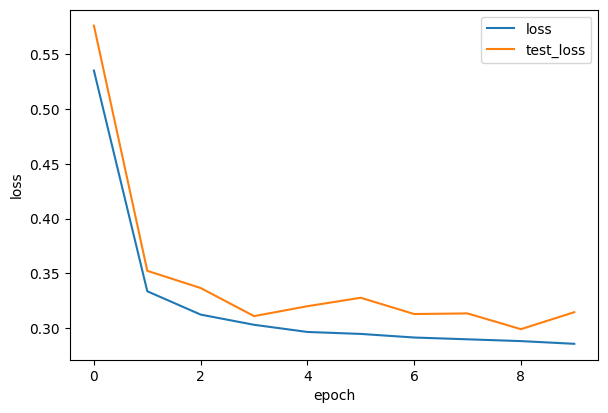

In [34]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses[:], label="loss")
    ax.plot(test_losses[:], label="test_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    #ax.set_ylim(0.25, 0.4)
    #ax.set_xlim(1)

    # Plot ROC
#     X_test_in = X_test
#     Y_predict = model(X_test_in)
#     from sklearn.metrics import roc_curve, auc

#     fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
#     roc_auc = auc(fpr, tpr)
#     ax = plt.subplot(2, 2, 3)
#     ax.set_yscale("log")
#     ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
#     ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
#     ax.set_xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
#     ax.set_xlabel("true positive rate")
#     ax.set_ylabel("false positive rate")
#     ax.set_title(f"{title} receiver operating curve")
#     ax.legend(loc="lower right")
#     plt.show()

In [35]:
with torch.inference_mode():
    X_test_in = X_test
    Y_predict = model(X_test_in)

In [36]:
bkg_out = Y_predict[y_test == 0].cpu()
bkg_out = torch.nn.functional.log_softmax(bkg_out, dim=1)
bkg_out = np.exp(bkg_out.numpy())

In [37]:
hgg_out = Y_predict[y_test == 1].cpu()
hgg_out = torch.nn.functional.log_softmax(hgg_out, dim=1)
hgg_out = np.exp(hgg_out.numpy())

In [38]:
hbb_out = Y_predict[y_test == 2].cpu()
hbb_out = torch.nn.functional.log_softmax(hbb_out, dim=1)
hbb_out = np.exp(hbb_out.numpy())

In [39]:
len(torch.where(torch.argmax(Y_predict, axis=1) == 0)[0])

91608

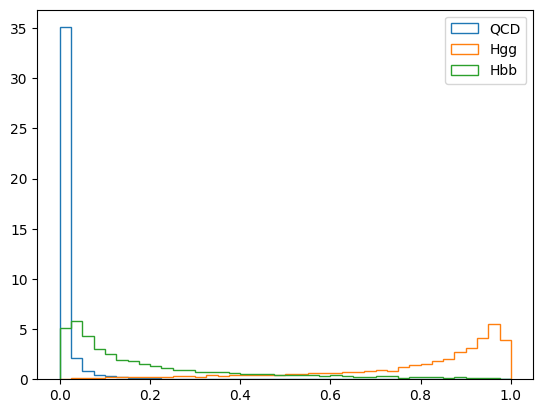

In [40]:
fig, ax = plt.subplots()
plt.hist(hgg_out[:,0], range=(0,1), bins=40, density=True, histtype='step', label='QCD')
plt.hist(hgg_out[:,1], range=(0,1), bins=40, density=True, histtype='step', label='Hgg')
plt.hist(hgg_out[:,2], range=(0,1), bins=40, density=True, histtype='step', label='Hbb')
plt.legend()
plt.show()

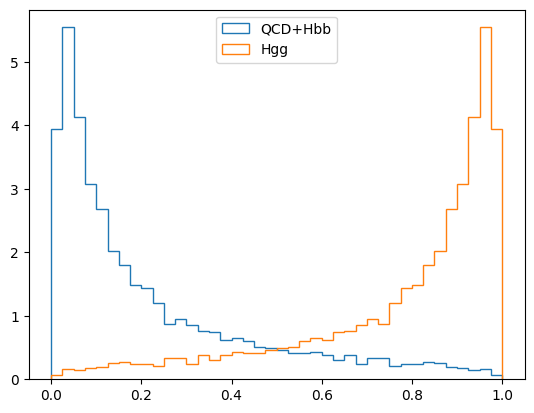

In [41]:
fig, ax = plt.subplots()
plt.hist(np.dstack([hgg_out[:,0],hgg_out[:,2]])[0].sum(axis=1), range=(0,1), bins=40, density=True, histtype='step', label='QCD+Hbb')
plt.hist(hgg_out[:,1], range=(0,1), bins=40, density=True, histtype='step', label='Hgg')
plt.legend()
plt.show()

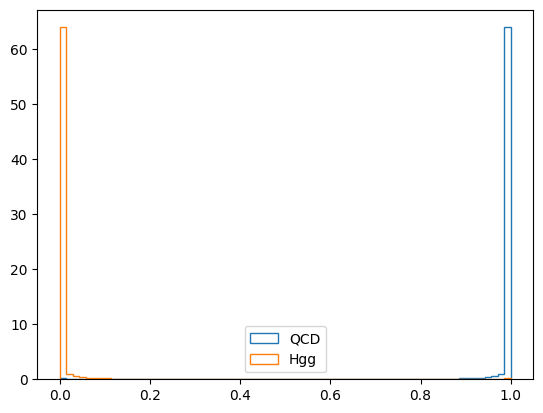

In [42]:
fig, ax = plt.subplots()
plt.hist(bkg_out[:,0], range=(0,1), bins=70, density=True, histtype='step', label='QCD')
plt.hist(bkg_out[:,1:].sum(axis=1), range=(0,1), bins=70, density=True, histtype='step', label='Hgg')
#plt.hist(bkg_out[:,2], range=(-50,50), bins=70, density=True, histtype='step', label='Hbb')
plt.legend()
plt.show()

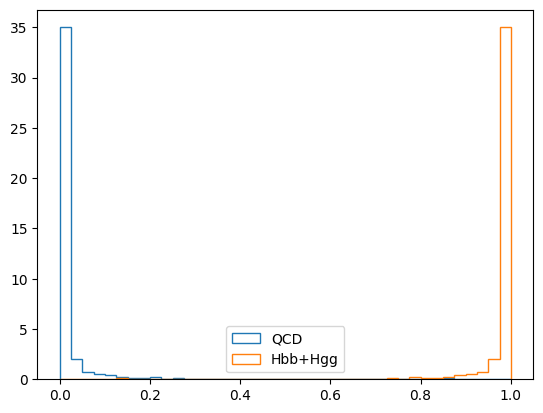

In [43]:
fig, ax = plt.subplots()
plt.hist(hbb_out[:,0], range=(0,1), bins=40, density=True, histtype='step', label='QCD')
#plt.hist(hbb_out[:,1], range=(0,1), bins=40, density=True, histtype='step', label='Hgg')
plt.hist(hbb_out[:,1:].sum(axis=1), range=(0,1), bins=40, density=True, histtype='step', label='Hbb+Hgg')
plt.legend()
plt.show()

In [44]:
tst = torch.argmax(Y_predict, axis=1).cpu().numpy()

In [45]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(bkg_out[:,0], bkg_out[:,1], bkg_out[:,2])
# ax.scatter(hgg_out[:,0], hgg_out[:,1], hgg_out[:,2])
# ax.scatter(hbb_out[:,0], hbb_out[:,1], hbb_out[:,2])
# plt.show()

In [46]:
def tri_maker(arg_out, var1, var2):    
    x = 0.5 * (2.*arg_out[:,var1]+arg_out[:,var2])
    y = 0.5*np.sqrt(3) * arg_out[:,var2]
    return x, y

In [47]:
x_hgg = tri_maker(hgg_out, 2, 0)
x_hbb = tri_maker(hbb_out, 2, 0)
x_bkg = tri_maker(bkg_out, 2, 0)

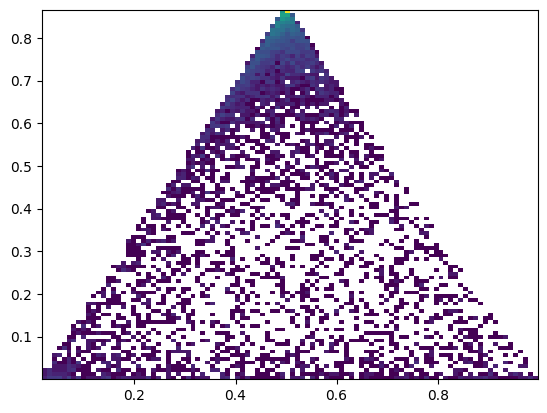

In [48]:
fig = plt.figure()
from matplotlib.colors import LogNorm
plt.hist2d(*x_bkg, bins=100, norm=LogNorm())

plt.show()

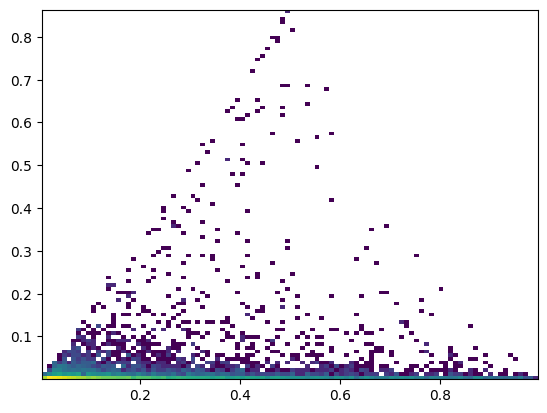

In [49]:
fig = plt.figure()
from matplotlib.colors import LogNorm
plt.hist2d(*x_hgg, bins=100, norm=LogNorm())

plt.show()

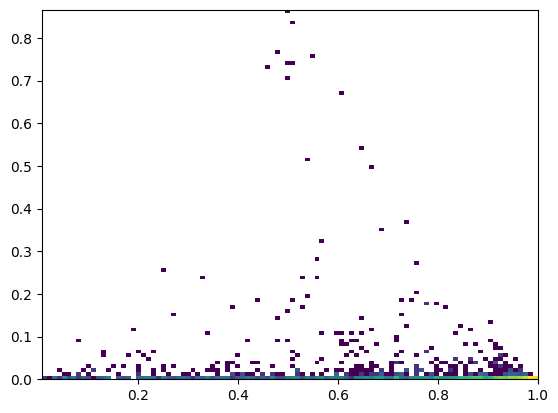

In [50]:
fig = plt.figure()
from matplotlib.colors import LogNorm
plt.hist2d(*x_hbb, bins=100, norm=LogNorm())

plt.show()

In [51]:
z, x, y = np.histogram2d(*x_hbb, bins=100)

In [52]:
z

array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [61.,  4.,  0., ...,  0.,  0.,  0.],
       [91.,  1.,  0., ...,  0.,  0.,  0.],
       [79.,  0.,  0., ...,  0.,  0.,  0.]])

In [53]:
import seaborn as sns

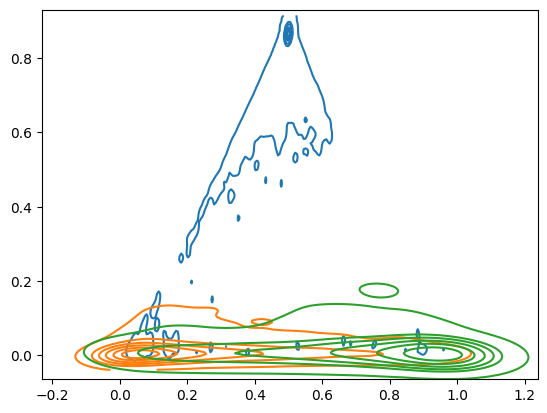

In [65]:
sns.kdeplot(x=x_bkg[0], y=x_bkg[1], levels=7, thresh=0.025);
sns.kdeplot(x=x_hgg[0], y=x_hgg[1], levels=7, thresh=0.04);
sns.kdeplot(x=x_hbb[0], y=x_hbb[1], levels=7, thresh=0.04);

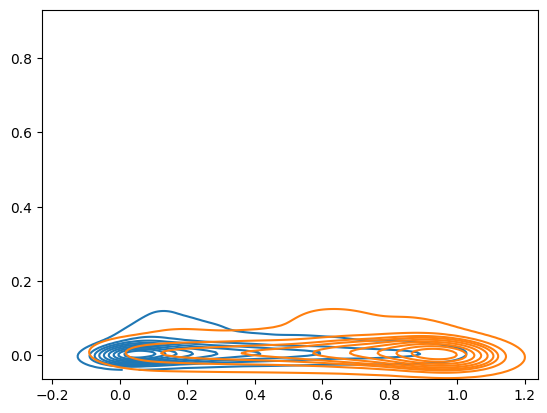

In [55]:
sns.kdeplot(x=x_hgg[0], y=x_hgg[1]);
sns.kdeplot(x=x_hbb[0], y=x_hbb[1]);